In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from torch_geometric.nn import global_add_pool, GATConv, CGConv, VGAE,GCNConv, RGCNConv, global_mean_pool
import pickle
from itertools import combinations
from sklearn.model_selection import train_test_split
from torch_geometric.data import DataLoader, Data
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from tqdm import tqdm
import torch.optim as optim
import math
from torch_geometric.data import DataLoader
from torch_geometric.nn import RGCNConv, global_mean_pool
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset, DataLoader
import pickle
from torch.optim import Adam, RMSprop
from tqdm import tqdm
from rdkit.Chem.rdMolDescriptors import CalcMolFormula


In [2]:
from contextlib import contextmanager
import sys
import os
import torch
from ase import Atoms
from ase.data import chemical_symbols
from ase.calculators.morse import MorsePotential
from ase.optimize import QuasiNewton
import numpy as np
import pickle
from rdkit.Chem import rdchem

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ase import Atoms
from ase.io import read
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
# from torch_geometric.data import DataLoader, TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from ase.build import molecule
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from torch_geometric.nn import global_add_pool, GATConv, CGConv, GCNConv, RGCNConv
from torch_geometric.nn.models.schnet import GaussianSmearing
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle
from collections import Counter
import seaborn as sns
import time
from torch.optim.lr_scheduler import StepLR
import torch
from torch_geometric.data import Data
from dscribe.descriptors import SOAP, ACSF, CoulombMatrix

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def debug_nan(tensor, name="Tensor"):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        print(tensor)

In [5]:
class RGCN_VGAE(nn.Module):
    def __init__(self, in_channels, out_channels, num_relations, num_node_features, max_nodes, bond_dim, atom_dim):
        super(RGCN_VGAE, self).__init__()
        self.num_relations = num_relations
        self.max_nodes = max_nodes
        self.atom_dim = atom_dim
        self.bond_dim = bond_dim

        self.rgcn1 = RGCNConv(in_channels, out_channels, num_relations=num_relations)
        self.rgcn2 = RGCNConv(out_channels, out_channels, num_relations=num_relations)
        self.rgcn3 = RGCNConv(out_channels, out_channels, num_relations=num_relations)
        
        self.fc_mu = nn.Linear(out_channels, out_channels)
        self.fc_logvar = nn.Linear(out_channels, out_channels)
        
        self.adj_decoder = nn.Sequential(
            nn.Linear(out_channels + 252, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, max_nodes * max_nodes * bond_dim)
        )
        self.feature_decoder = nn.Linear(out_channels + 252, max_nodes * atom_dim)
        
        self.cond_pool1 = nn.AdaptiveAvgPool1d(9901)
        self.cond_linear1 = nn.Linear(9901, 3_808)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        conditional = data.descriptor
        edge_attr = torch.argmax(edge_attr, dim=1).long()

        # print(x.shape)
        # print(edge_index.shape)
        # print(edge_attr.shape)
        x = F.relu(self.rgcn1(x, edge_index, edge_attr))
        x = F.relu(self.rgcn2(x, edge_index, edge_attr))
        # x = F.relu(self.rgcn3(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        conditional = conditional.transpose(0,1)
        conditional = conditional.unsqueeze(1)
        conditional = self.cond_pool1(conditional)
        # conditional = conditional.view(1, -1)
        conditional = self.cond_linear1(conditional)
        conditional = conditional.view(952, -1).squeeze(0)

        z = self.reparameterize(mu, logvar)
        z = torch.cat((z, conditional), dim=1)

        A_pred = self.adj_decoder(z).view(-1, self.max_nodes, self.max_nodes, self.bond_dim)
        A_pred = F.softmax(A_pred, dim=-1)

        features_pred = self.feature_decoder(z).view(-1, self.max_nodes, self.atom_dim)
        features_pred = F.softmax(features_pred, dim=-1)
        
        return A_pred, features_pred, mu, logvar
    
    def decode(self, z):    
        A_pred = self.adj_decoder(z).view(-1, self.max_nodes, self.max_nodes, self.bond_dim)
        A_pred = F.softmax(A_pred, dim=-1)

        features_pred = self.feature_decoder(z).view(-1, self.max_nodes, self.atom_dim)
        features_pred = F.softmax(features_pred, dim=-1)
        
        return A_pred, features_pred

In [6]:
# with open("../data/combined_data.pkl", "rb") as file:
#     combined_data = pickle.load(file)

atomic_number_tensors = torch.load("data/atomic_number_tensors.pt")
bond_tensors = torch.load("data/bond_tensors.pt")

In [7]:
NUM_ATOMS = 63
ATOM_DIM = 11
BOND_DIM = 5
LATENT_DIM = 256
HIDDEN_CHANNELS = 128
NUM_RELATION_TYPES = BOND_DIM - 1
NODE_FEATURE_DIM = ATOM_DIM - 1
# NODE_FEATURE_DIM = ATOM_DIM
BATCH_SIZE = 512
NUM_EPOCHS = 300

In [8]:
model = RGCN_VGAE(NODE_FEATURE_DIM, LATENT_DIM, NUM_RELATION_TYPES, NODE_FEATURE_DIM, NUM_ATOMS, BOND_DIM, ATOM_DIM).to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
class GraphDataset(Dataset):
    def __init__(self, adjacency_matrices, atom_features):
        self.adjacency_matrices = adjacency_matrices
        self.atom_features = atom_features

    def __len__(self):
        return self.adjacency_matrices.size(0)

    def __getitem__(self, idx):
        return self.adjacency_matrices[idx], self.atom_features[idx]
    
dataset = GraphDataset(bond_tensors, atomic_number_tensors)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
weights_atoms = torch.ones(ATOM_DIM).to(device)
weights_bonds = torch.ones(BOND_DIM).to(device)

weights_atoms[0] = 0.5
weights_atoms[10] = 8
weights_bonds[4] = 0.5

weights_atoms.to(device)
weights_bonds.to(device)

def calculate_kl_divergence(mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_divergence

# def calculate_uniqueness_loss(bonds_pred, atoms_pred):
#     datapoints = process_graph_data_to_data_objects(bonds_pred, atoms_pred)
#     num_unique = 0
#     seen_set = set()
#     for dp in datapoints:
#         mol, formula = to_chemula(dp)
#         if formula not in seen_set:
#             num_unique += 1
#             seen_set.add(formula)
#     return num_unique

def loss_function(preds, labels, mu, logvar, preds_atomic, atomic_numbers, lambda_kld, device):

    batch_size = preds.shape[0]
    labels = torch.argmax(labels, dim=-1)
    atomic_numbers = torch.argmax(atomic_numbers, dim=-1)
    preds, labels = preds.to(device), labels.to(device)
    preds_atomic, atomic_numbers = preds_atomic.to(device), atomic_numbers.to(device)
    mu, logvar = mu.to(device), logvar.to(device)

    # print(preds.shape)
    # print(labels.shape)
    # print(preds_atomic.shape)
    # print(atomic_numbers.shape)

    ce_bond = F.cross_entropy(preds.view(-1, preds.size(-1)), labels.view(-1), weight=weights_bonds.to(device))
    ce_atomic = F.cross_entropy(preds_atomic.view(-1, preds_atomic.size(-1)), atomic_numbers.view(-1), weight=weights_atoms.to(device))
    
    kld = calculate_kl_divergence(mu, logvar)

    atom_presence_mask = torch.argmax(preds_atomic, dim=-1) != 10
    atom_count = torch.sum(atom_presence_mask)
    atom_count = atom_count / batch_size
    atomic_regulizer = atom_count / batch_size * 3


    bond_presence_mask = torch.argmax(preds, dim=-1) != 4
    bond_count = torch.sum(bond_presence_mask)
    bond_count = bond_count / batch_size

    if int(atom_count) <= 50:
        print(atom_count)
        atomic_regulizer = 2000 - 10 * int(atom_count)

    if bond_count < 100:
        bond_regulizer = 0.0
    elif bond_count <= 50:
        bond_regulizer = 2000 - 5 * bond_count
    else:
        bond_regulizer = 10

    # unique_counts = set()

    # for b in preds_atomic:
    #     atom_counts = np.zeros(11, dtype=int)
    #     for j in range(63):
    #         for k in range(11):
    #             if b[j, k] == 1:
    #                 atom_counts[k] += 1
    #     counts_tuple = tuple(atom_counts)
    #     unique_counts.add(counts_tuple)

    # num_same = len(unique_counts)
    # print(num_same)

    total_loss = 0.7 * ce_bond + lambda_kld * kld + 1.9 * ce_atomic + 0.6 * atomic_regulizer + 0.2 * bond_regulizer

    print(kld, ce_atomic, ce_bond, atomic_regulizer, bond_regulizer)
    return total_loss


In [12]:
atomic_mapping = {0: 6, 1: 7, 2:8, 3:9, 4:14, 5:15, 6:16, 7:17, 8:35, 9:53}

In [13]:
def create_feature_descriptor(atomic_nums):
    numbers = torch.argmax(atomic_nums, dim=-1)
    numbers = [atomic_mapping[index.item()] for index in numbers if index < 10]

    positions = np.random.rand(len(numbers), 3) * 10

    atoms = Atoms(numbers=numbers, positions=positions)

    cm = CoulombMatrix(n_atoms_max=len(numbers), permutation="sorted_l2")

    cm_descriptor = cm.create(atoms).reshape(len(numbers), len(numbers))
    if len(numbers) < 63:
        cm_descriptor = np.pad(cm_descriptor, ((0, 63 - len(numbers)), (0, 63 - len(numbers))), mode='constant', constant_values=0)
    return cm_descriptor

In [14]:
def process_graph_data_to_data_objects(batch_adjacency, batch_atoms, grad = False):
    batch_size = batch_adjacency.shape[0]
    num_nodes = batch_adjacency.shape[1]
    num_bond_types = batch_adjacency.shape[3] - 1 
    num_atom_types = batch_atoms.shape[2] - 1
    # print(num_atom_types)
    
    data_objects = []

    for idx in range(batch_size):
        edge_index = []
        edge_attr = []
        x = []
        node_index_map = {}
        
        adjacency = batch_adjacency[idx]
        atoms = batch_atoms[idx]
        
        new_idx = 0
            
        descriptor = torch.tensor(create_feature_descriptor(atoms), dtype=torch.float32)
        # padded_descriptor = np.pad(descriptor, ((0, 0), (0, 9000 - descriptor.shape[1])), mode='constant', constant_values=0)
        # padded_descriptor = torch.tensor(padded_descriptor)
        # print(padded_descriptor.shape)

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                bond_type = torch.argmax(adjacency[i, j])
                # if adjacency[i,j][num_bond_types] > 0.18:
                #     # print('overwrite')
                    # continue
                if bond_type < num_bond_types:  # Bond exists
                    atom_type_i = torch.argmax(atoms[i])
                    atom_type_j = torch.argmax(atoms[j])
                    if atom_type_i == num_atom_types or atom_type_j == num_atom_types: # Both atoms must exist
                        continue
                    if i not in node_index_map:
                        node_index_map[i] = new_idx
                        new_idx+=1
                        x.append(torch.nn.functional.one_hot(torch.argmax(atoms[i]), num_classes=num_atom_types).float())
                    if j not in node_index_map:
                        node_index_map[j] = new_idx
                        new_idx+=1
                        x.append(torch.nn.functional.one_hot(torch.argmax(atoms[j]), num_classes=num_atom_types).float())
                    edge_index.append([node_index_map[i], node_index_map[j]])
                    bond_one_hot = torch.zeros(num_bond_types)
                    bond_one_hot[bond_type] = 1
                    edge_attr.append(bond_one_hot)
                    # print(bond_type)
                    # edge_attr.append(bond_type/num_bond_types)

        if edge_index:
            edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_attr_tensor = torch.stack(edge_attr, dim=0)

        else:
       
            edge_index_tensor = torch.empty((2, 0), dtype=torch.long)
            edge_attr_tensor = torch.empty((0, num_bond_types), dtype=torch.float)
            

        if x:
            node_features_tensor = torch.stack(x, dim=0)
        else:
           
            node_features_tensor = torch.empty((0, num_atom_types), dtype=torch.float)

   
        # if grad:
        #     node_features_tensor.requires_grad_(True)
        #     edge_attr.requires_grad_(True)
        graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor, adj_matrix=adjacency, node_features=atoms, descriptor=descriptor)
        data_objects.append(graph_data)

    return data_objects

In [15]:
data_dataset = []
for adj_matrix, node_features in dataloader:
    adj_matrix.to(device)
    node_features.to(device)
    data = process_graph_data_to_data_objects(adj_matrix, node_features)
    data_dataset.append(data)

data_object_loader = DataLoader(data_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
for b in data_object_loader:
    print(b[2])
    break

DataBatch(x=[134, 10], edge_index=[2, 137], edge_attr=[137, 4], adj_matrix=[441, 63, 5], node_features=[441, 11], descriptor=[441, 63], batch=[134], ptr=[8])


In [17]:
num_epochs = 700
for epoch in range(num_epochs):
    total_loss = 0
    #lambda_kld = min(1.0, 0.01 +  epoch/ num_epochs)
    lambda_kld = 1.3
    batch_count = 0
    for data in data_object_loader:
        # print(adj_matrix.shape)
        optimizer.zero_grad()

        # adj_matrix.to(device)
        # node_features.to(device)
        
        # data = process_graph_data_to_data_objects(adj_matrix, node_features)
        data = Batch.from_data_list(data).to(device)

        reconstructed, reconstructed_atoms, mu, logvar = model(data)
        
        loss = loss_function(
            reconstructed, data.adj_matrix, 
            mu, logvar, 
            reconstructed_atoms, data.node_features, 
            lambda_kld, device
        )
        total_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        print(f"Gradients of {name}: {param.grad}")

    # Calculate average loss for reporting
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

tensor(503.1967, device='cuda:0', grad_fn=<MulBackward0>) tensor(2.4052, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.6176, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.1808, device='cuda:0') 10
Epoch 1, Loss: 661.9663696289062
tensor(470.3438, device='cuda:0', grad_fn=<MulBackward0>) tensor(2.3978, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.6149, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.1784, device='cuda:0') 10
Epoch 2, Loss: 619.240234375
tensor(439.8306, device='cuda:0', grad_fn=<MulBackward0>) tensor(2.3831, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.1745, device='cuda:0') 10
Epoch 3, Loss: 579.5406494140625
tensor(411.4766, device='cuda:0', grad_fn=<MulBackward0>) tensor(2.3750, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(0.1721, device='cuda:0') 10
Epoch 4, Loss: 542.6612548828125
tensor(385.1368, dev

### Use if Sampling with Conditioning

In [18]:
def sample_latent_space(mu, logvar, num_samples=1):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)  # Random noise
    return mu + eps * std

### Use if Sampling without Conditioning

In [19]:
def sample_z(latent_dim, num_samples=1, device="cuda"):
    return torch.randn(num_samples, latent_dim).to(device)

In [20]:
def generate_graph(model, num_samples=1, latent_dim=LATENT_DIM+252, device="cuda"):
    z = sample_z(latent_dim, num_samples, device)
    
    with torch.no_grad(): 
        A_pred, features_pred = model.decode(z)
    
    return A_pred, features_pred

In [21]:
atomic_mapping = {0: 6, 1: 7, 2:8, 3:9, 4:14, 5:15, 6:16, 7:17, 8:35, 9:53}

In [22]:
def get_bond_type(bond_type):
    bond_type = torch.argmax(bond_type, dim=-1).item()
    if bond_type == 0:
        return rdchem.BondType.SINGLE
    elif bond_type == 1:
        return rdchem.BondType.DOUBLE
    elif bond_type == 2:
        return rdchem.BondType.TRIPLE
    elif bond_type == 3:
        return rdchem.BondType.AROMATIC
    else:
        return None

In [23]:
def is_valid(data):
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    atomic_numbers = []
    for num in node_features.argmax(dim=-1).tolist():
        atomic_numbers.append(atomic_mapping[num])

    mol = Chem.RWMol()
    for atomic_num in atomic_numbers:
        atom = Chem.Atom(atomic_num)
        mol.AddAtom(atom)

    for i, (bond_start, bond_end) in enumerate(edge_index.t().tolist()):
        bond_val = edge_attr[i]
        bond_type = get_bond_type(bond_val)
        mol.AddBond(bond_start, bond_end, bond_type)

    validity = Chem.SanitizeMol(mol, catchErrors=True)

    return validity == Chem.SanitizeFlags.SANITIZE_NONE

In [24]:
unique_molecules = set()
def is_unique(data):
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    atomic_numbers = []
    for num in node_features.argmax(dim=-1).tolist():
        atomic_numbers.append(atomic_mapping[num])

    mol = Chem.RWMol()
    for atomic_num in atomic_numbers:
        atom = Chem.Atom(atomic_num)
        mol.AddAtom(atom)

    for i, (bond_start, bond_end) in enumerate(edge_index.t().tolist()):
        bond_val = edge_attr[i]
        bond_type = get_bond_type(bond_val)
        mol.AddBond(bond_start, bond_end, bond_type)

    canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
    if canonical_smiles not in unique_molecules:
        unique_molecules.add(canonical_smiles)
        return True
    else:
        return False

In [25]:
# torch.save(model.state_dict(), "models/vae_model_conditioning.pt")

In [26]:
print(model)

RGCN_VGAE(
  (rgcn1): RGCNConv(10, 256, num_relations=4)
  (rgcn2): RGCNConv(256, 256, num_relations=4)
  (rgcn3): RGCNConv(256, 256, num_relations=4)
  (fc_mu): Linear(in_features=256, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=256, bias=True)
  (adj_decoder): Sequential(
    (0): Linear(in_features=508, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=19845, bias=True)
  )
  (feature_decoder): Linear(in_features=508, out_features=693, bias=True)
  (cond_pool1): AdaptiveAvgPool1d(output_size=9901)
  (cond_linear1): Linear(in_features=9901, out_features=3808, bias=True)
)


In [27]:
import re
def expand_formula(formula):
    pattern = r'([A-Z][a-z]?)(\d*)'
    expanded_list = []
    total_atoms = 0

    matches = re.findall(pattern, formula)
    for element, count in matches:
        count = int(count) if count else 1
        expanded_list.extend([element] * count)
        total_atoms += count

    return expanded_list, total_atoms

In [28]:
def get_molecule(datapoint):
    _, formula = to_chemula(datapoint)
    l, total_atoms = expand_formula(formula)

    # #atomic_numbers = datapoint.x.argmax(dim=1).tolist()
    # atomic_numbers_unmapped = datapoint.x.argmax(dim=1).tolist()
    # atomic_numbers = []
    # for at in atomic_numbers_unmapped:
    #     atomic_numbers.append(atomic_mapping[at])
    # positions = datapoint.positions.numpy()
    positions = np.random.rand(len(l), 3) * 10  

    # molecule = Atoms(numbers=atomic_numbers, positions=positions)
    molecule = Atoms(symbols=l, positions=positions)

    return molecule, total_atoms

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def get_dft(datapoint, De=0.242, re=0.74, alpha=1.5):
    molecule, _ = get_molecule(datapoint)
    print('Molecule:', molecule)
    dft_calculator = MorsePotential(De=De, r0=re, alpha=alpha)
    molecule.set_calculator(dft_calculator)
    # energy = molecule.get_potential_energy()
    with suppress_stdout():
        opt = QuasiNewton(molecule)
        opt.run(fmax=0.02)
    optimized_energy = molecule.get_potential_energy()
    return optimized_energy

# energy = get_dft(datapoint)

# print(f'DFT Energy: {energy} eV')

In [29]:
def to_chemula(data):
    node_features = data.x
    edge_index = data.edge_index
    edge_attr = data.edge_attr

    atomic_numbers = []
    for num in node_features.argmax(dim=-1).tolist():
        atomic_numbers.append(atomic_mapping[num])

    mol = Chem.RWMol()
    for atomic_num in atomic_numbers:
        atom = Chem.Atom(atomic_num)
        mol.AddAtom(atom)

    for i, (bond_start, bond_end) in enumerate(edge_index.t().tolist()):
        bond_val = edge_attr[i]
        bond_type = get_bond_type(bond_val)
        mol.AddBond(bond_start, bond_end, bond_type)
        
    for atom in mol.GetAtoms():
        atom.UpdatePropertyCache(strict=False)
    # Chem.SanitizeMol(mol)
    return mol, CalcMolFormula(mol)

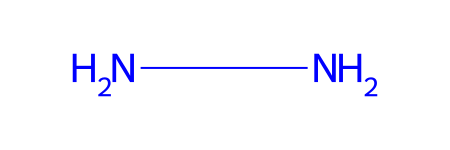

In [30]:
Chem.MolFromSmiles('NN')

In [31]:
class GraphEncoder(nn.Module):
    def __init__(self, input_dim, num_relations):
        super(GraphEncoder, self).__init__()
        self.rgcnconv1 = RGCNConv(input_dim, 512, num_relations=num_relations)
        self.rgcnconv2 = RGCNConv(512, 256, num_relations=num_relations)
        self.rgcnconv3 = RGCNConv(256, 128, num_relations=num_relations)

    def forward(self, x, edge_index, edge_attr):
        x = self.rgcnconv1(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        x = self.rgcnconv2(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        x = self.rgcnconv3(x, edge_index, edge_attr)
        x = nn.ReLU()(x)
        return x

class BioClassifier(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(BioClassifier, self).__init__()

        self.encoder = GraphEncoder(input_dim, num_heads)
        self.fc1 = nn.Linear(128, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = x.float()

        x = self.encoder(x, edge_index, edge_attr)
        x = global_add_pool(x, data.batch)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x.squeeze(dim=1)

In [32]:
model_bio_eval = BioClassifier(10, 4).to(device)

state_dict = torch.load('models/rcgn_model_7428.pt')
model_bio_eval.load_state_dict(state_dict)

model_bio_eval.eval()
def get_model_prediction(datapoint):
    pred = model_bio_eval(datapoint)
    return pred.item()

In [33]:
# print(datapoint)
# datapoint.edge_attr = torch.argmax(datapoint.edge_attr, dim=1).to(device)
# datapoint.edge_index = datapoint.edge_index.to(device)
# datapoint.x = datapoint.x.to(device)

In [34]:
# print(datapoint.edge_attr)

In [35]:
# dft = get_dft(datapoint)
# y = get_model_prediction(datapoint) * 100

# print(f'DFT (remember negative is good): {dft}')
# print(f'Chance of Biodgradability: {y:.2f}%')

## Generating from Our Latent Space

In [36]:
# generated_list_ours = []
# list_len = 100
# for i in tqdm(range(list_len)):
#     bonds_pred_ours, atoms_pred_ours = generate_graph_ours(model)
#     datapoints = process_graph_data_to_data_objects(bonds_pred_ours, atoms_pred_ours)
#     datapoint = datapoints[0]
#     validity = is_valid(datapoint)
#     mol, formula = to_chemula(datapoint)
#     ase_atoms = get_molecule(datapoint)
#     energy = get_dft(datapoint)
#     datapoint.edge_attr = torch.argmax(datapoint.edge_attr, dim=1).to(device)
#     datapoint.edge_index = datapoint.edge_index.to(device)
#     datapoint.x = datapoint.x.to(device)
#     y = get_model_prediction(datapoint) * 100
#     generated_list_ours.append({"bond_preds": bonds_pred, "atom_preds": atoms_pred, "is_valid": validity, "ase_atom": ase_atoms, "mol": mol, "formula": formula, "energy":energy, "bio":y})

## Generating from Rand Normal Distribution

In [37]:
generated_list = []

num_errors = 0

while len(generated_list) < 100:
    try:
        bonds_pred, atoms_pred = generate_graph(model)
        datapoints = process_graph_data_to_data_objects(bonds_pred, atoms_pred)
        datapoint = datapoints[0]
        validity = is_valid(datapoint)
        mol, formula = to_chemula(datapoint)
        ase_atoms, total_atoms = get_molecule(datapoint)
        energy = get_dft(datapoint)
        datapoint.edge_attr = torch.argmax(datapoint.edge_attr, dim=1).to(device)
        datapoint.edge_index = datapoint.edge_index.to(device)
        datapoint.x = datapoint.x.to(device)
        y = get_model_prediction(datapoint) * 100
        generated_list.append({"atom_count": total_atoms, "is_valid": validity, "ase_atom": ase_atoms, "mol": mol, "formula": formula, "energy":energy, "bio":y})
    except Exception as e:
        num_errors += 1
        print("ERROR!!!!!!")
        # print(e)
print(num_errors)

[03:10:40] Explicit valence for atom # 0 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='C3H26Br3ClF3I4N2OP4S2Si4', pbc=False)


[03:10:41] Explicit valence for atom # 5 Cl, 3, is greater than permitted


Molecule: Atoms(symbols='C5H24Br3Cl3FI4NP3SSi4', pbc=False)


[03:10:43] Explicit valence for atom # 1 F, 2, is greater than permitted


Molecule: Atoms(symbols='C5H13BrClF2O2S', pbc=False)


[03:10:43] Explicit valence for atom # 2 Si, 7, is greater than permitted


Molecule: Atoms(symbols='C6H22Br2Cl3FI3N2O5P3S4Si4', pbc=False)
Molecule: Atoms(symbols='C2H11FI2NPS', pbc=False)
Molecule: Atoms(symbols='H10Br4F2N2OPSSi2', pbc=False)


[03:10:45] non-ring atom 0 marked aromatic
[03:10:45] non-ring atom 3 marked aromatic


Molecule: Atoms(symbols='CH11Br2Cl2F3I3N2OSSi2', pbc=False)


[03:10:45] Explicit valence for atom # 2 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='CH11Cl2IOP2SSi2', pbc=False)
Molecule: Atoms(symbols='C5H15BrFN', pbc=False)
Molecule: Atoms(symbols='C4H16Br4Cl4F4I6N4O4PSSi3', pbc=False)


[03:10:46] Explicit valence for atom # 7 Br, 2, is greater than permitted
[03:10:48] Explicit valence for atom # 2 Cl, 4, is greater than permitted


Molecule: Atoms(symbols='C4H24Br6Cl7F3I3O4P9S4Si6', pbc=False)


[03:10:51] non-ring atom 1 marked aromatic
[03:10:51] Explicit valence for atom # 4 Br, 3, is greater than permitted


Molecule: Atoms(symbols='CH3BrF2NOS', pbc=False)
Molecule: Atoms(symbols='C5H13Br2ClF2NP2', pbc=False)


[03:10:52] Explicit valence for atom # 1 Br, 3, is greater than permitted
[03:10:52] Explicit valence for atom # 1 Br, 6, is greater than permitted


Molecule: Atoms(symbols='CH10Br2F3N3O2S', pbc=False)
Molecule: Atoms(symbols='C4H14Br7Cl3FI6N5O6P4S4Si9', pbc=False)


[03:10:55] Explicit valence for atom # 1 Br, 2, is greater than permitted


Molecule: Atoms(symbols='C6H20Br4Cl4F4I4N4O4PS3Si8', pbc=False)


[03:10:58] Explicit valence for atom # 1 F, 2, is greater than permitted


Molecule: Atoms(symbols='H16Br4Cl2F3IN4O3P4SSi3', pbc=False)


[03:10:58] Explicit valence for atom # 11 O, 5, is greater than permitted


Molecule: Atoms(symbols='C4H14Cl3FI3NO5P7Si3', pbc=False)


[03:10:59] Explicit valence for atom # 1 Br, 2, is greater than permitted
[03:10:59] Explicit valence for atom # 2 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='HBr2FNOPS', pbc=False)
Molecule: Atoms(symbols='CH12Br2Cl2F6IN2O2P2Si2', pbc=False)


[03:11:00] Explicit valence for atom # 3 O, 5, is greater than permitted
[03:11:00] Explicit valence for atom # 6 F, 2, is greater than permitted


Molecule: Atoms(symbols='CH15BrCl3FN2O2PSSi3', pbc=False)
Molecule: Atoms(symbols='C4H19Br3Cl4F4I3NOP2S7Si', pbc=False)


[03:11:01] Explicit valence for atom # 9 Br, 2, is greater than permitted


Molecule: Atoms(symbols='CH6Br4Cl2F6IO3P3S2Si2', pbc=False)


[03:11:01] Explicit valence for atom # 8 Br, 2, is greater than permitted


Molecule: Atoms(symbols='C2H9Br5Cl2IN2OPSSi', pbc=False)


[03:11:02] non-ring atom 1 marked aromatic
[03:11:02] Explicit valence for atom # 0 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='CH7Cl2FIPS2Si2', pbc=False)
Molecule: Atoms(symbols='CH12Cl2FINO2P2S3Si2', pbc=False)


[03:11:02] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='C2H17BrN3PSSi3', pbc=False)


[03:11:02] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='C2H14BrClFIN2OPSSi2', pbc=False)


[03:11:03] Explicit valence for atom # 0 Cl, 4, is greater than permitted


Molecule: Atoms(symbols='C2H18Br2Cl3F3IN3O4P5SSi4', pbc=False)


[03:11:03] Explicit valence for atom # 2 Br, 2, is greater than permitted
[03:11:03] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='H2BrFPS', pbc=False)
Molecule: Atoms(symbols='C2H12BrFIN2OPSi', pbc=False)
Molecule: Atoms(symbols='C2H7N', pbc=False)
Molecule: Atoms(symbols='C4H11Br10Cl4F6I6N6O2P2S2Si2', pbc=False)


[03:11:04] Explicit valence for atom # 4 Br, 5, is greater than permitted
[03:11:05] Explicit valence for atom # 14 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='C3H12Cl2FOP2S3Si3', pbc=False)


[03:11:05] Explicit valence for atom # 7 F, 4, is greater than permitted


Molecule: Atoms(symbols='C4H17F3INPSi', pbc=False)


[03:11:06] non-ring atom 3 marked aromatic
[03:11:06] Explicit valence for atom # 2 Br, 5, is greater than permitted


Molecule: Atoms(symbols='C2H11BrINSSi', pbc=False)
Molecule: Atoms(symbols='C4H19BrClF3I2N2O4P2S2Si3', pbc=False)


[03:11:07] Explicit valence for atom # 1 F, 2, is greater than permitted
[03:11:07] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='C2H9ClFN2O3', pbc=False)
Molecule: Atoms(symbols='C3H7Cl2IN2', pbc=False)


[03:11:07] non-ring atom 3 marked aromatic


Molecule: Atoms(symbols='C2H12ClO3PSSi', pbc=False)


[03:11:07] Explicit valence for atom # 5 Br, 2, is greater than permitted


Molecule: Atoms(symbols='C2H12BrF2I2NOSSi', pbc=False)


[03:11:08] non-ring atom 4 marked aromatic
[03:11:08] non-ring atom 3 marked aromatic


Molecule: Atoms(symbols='C4H14ClNO2P2S', pbc=False)
Molecule: Atoms(symbols='CH4Cl2I2NO', pbc=False)


[03:11:08] non-ring atom 2 marked aromatic


Molecule: Atoms(symbols='C2H13IN4O3Si', pbc=False)


[03:11:08] non-ring atom 3 marked aromatic
[03:11:09] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='CH10ClFNO2Si2', pbc=False)
Molecule: Atoms(symbols='C4H19Cl2FNP3S', pbc=False)


[03:11:09] Explicit valence for atom # 14 Br, 3, is greater than permitted


Molecule: Atoms(symbols='CH13Br3FI4N4PS4Si', pbc=False)


[03:11:09] Explicit valence for atom # 2 F, 4, is greater than permitted


Molecule: Atoms(symbols='CH14F2N3OSSi3', pbc=False)


[03:11:10] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[03:11:10] Explicit valence for atom # 1 F, 2, is greater than permitted


Molecule: Atoms(symbols='C2H7Br2Cl2S4Si', pbc=False)
Molecule: Atoms(symbols='CH8BrCl3F2P2S2', pbc=False)


[03:11:10] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='CH9Br2ClI3OSi3', pbc=False)


[03:11:10] Explicit valence for atom # 1 F, 2, is greater than permitted


Molecule: Atoms(symbols='C3H14BrF2IN2O3P3S2Si', pbc=False)


[03:11:11] Explicit valence for atom # 1 Br, 2, is greater than permitted
[03:11:11] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='C2H7Br2Cl2F4PS3', pbc=False)
Molecule: Atoms(symbols='C2H10Br3Cl4NO2S2Si', pbc=False)


[03:11:11] Explicit valence for atom # 5 Cl, 4, is greater than permitted


Molecule: Atoms(symbols='C3H19Br3Cl4F3I2O2P2S3Si4', pbc=False)
Molecule: Atoms(symbols='CH3O3S2', pbc=False)
Molecule: Atoms(symbols='CH8BrCl3F2I4N3O3P2Si', pbc=False)


[03:11:12] Explicit valence for atom # 1 I, 6, is greater than permitted
[03:11:12] Explicit valence for atom # 5 F, 4, is greater than permitted


Molecule: Atoms(symbols='CH5Br2FI3N2PSSi', pbc=False)


[03:11:13] Explicit valence for atom # 3 Br, 4, is greater than permitted


Molecule: Atoms(symbols='C3H16Br3Cl3F2I3O3P3S2Si3', pbc=False)


[03:11:15] Explicit valence for atom # 6 Br, 3, is greater than permitted


Molecule: Atoms(symbols='H7Br2IN2OPSi', pbc=False)


[03:11:15] non-ring atom 1 marked aromatic


Molecule: Atoms(symbols='H6Br3F2INOP5', pbc=False)


[03:11:15] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[03:11:15] Explicit valence for atom # 2 Br, 3, is greater than permitted


Molecule: Atoms(symbols='CH4BrCl2FINO2PS3', pbc=False)
Molecule: Atoms(symbols='C2H4Br2F3O3PS2', pbc=False)


[03:11:15] Explicit valence for atom # 2 Cl, 4, is greater than permitted


Molecule: Atoms(symbols='C4H20Br3Cl2F4I2N2OP2SSi2', pbc=False)


[03:11:16] Explicit valence for atom # 1 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='H19Br4Cl5F2IN2O3P2S4Si4', pbc=False)


[03:11:17] Explicit valence for atom # 8 O, 3, is greater than permitted


Molecule: Atoms(symbols='CH11Br2Cl3IN2O3P2SSi', pbc=False)


[03:11:17] non-ring atom 4 marked aromatic


Molecule: Atoms(symbols='C4H14FINO2P', pbc=False)


[03:11:18] Explicit valence for atom # 2 F, 2, is greater than permitted
[03:11:18] Explicit valence for atom # 1 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='C2H9F2N2S2', pbc=False)
Molecule: Atoms(symbols='C2H11Cl3NO2PS2', pbc=False)


[03:11:18] non-ring atom 4 marked aromatic


Molecule: Atoms(symbols='CH11BrClFI3NP4SSi3', pbc=False)


[03:11:18] non-ring atom 1 marked aromatic
[03:11:18] Explicit valence for atom # 11 Br, 3, is greater than permitted


Molecule: Atoms(symbols='CH9INOPS2Si', pbc=False)
Molecule: Atoms(symbols='CH13BrClF4I2N2O4P3SSi', pbc=False)


[03:11:19] Explicit valence for atom # 0 O, 3, is greater than permitted


Molecule: Atoms(symbols='C8H9Br2Cl8F2I11N5O7P5S4Si4', pbc=False)


[03:11:22] non-ring atom 4 marked aromatic
[03:11:22] Explicit valence for atom # 1 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='CH11ClFIPSSi2', pbc=False)
Molecule: Atoms(symbols='CH8Cl3FISSi', pbc=False)


[03:11:22] Explicit valence for atom # 1 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='C5H23ClINO2PSSi', pbc=False)


[03:11:22] Explicit valence for atom # 5 Cl, 2, is greater than permitted
[03:11:22] Explicit valence for atom # 14 Br, 3, is greater than permitted


Molecule: Atoms(symbols='H3Cl7I2OP2', pbc=False)
Molecule: Atoms(symbols='CH10Br3Cl2F2I2NO2Si2', pbc=False)


[03:11:23] non-ring atom 4 marked aromatic
[03:11:23] Explicit valence for atom # 1 Br, 2, is greater than permitted


Molecule: Atoms(symbols='C3H9Cl2OSi', pbc=False)
Molecule: Atoms(symbols='CH7Br4FI2O2PS', pbc=False)


[03:11:23] Explicit valence for atom # 2 Cl, 2, is greater than permitted


Molecule: Atoms(symbols='C3H20Cl3INO3PSi2', pbc=False)


[03:11:23] Explicit valence for atom # 1 N, 8, is greater than permitted


Molecule: Atoms(symbols='C3H20BrClF4I5N4O5P4Si2', pbc=False)


[03:11:24] Explicit valence for atom # 7 F, 2, is greater than permitted


Molecule: Atoms(symbols='H7Br2Cl4FOPSSi2', pbc=False)


[03:11:25] Explicit valence for atom # 1 Br, 2, is greater than permitted


Molecule: Atoms(symbols='H5BrN4O2Si', pbc=False)
Molecule: Atoms(symbols='C2H9ClNO2PS', pbc=False)


[03:11:25] Explicit valence for atom # 10 F, 2, is greater than permitted


Molecule: Atoms(symbols='C5H13Br2FN2O3PSi', pbc=False)
Molecule: Atoms(symbols='C3H10INO', pbc=False)
Molecule: Atoms(symbols='CH5NS2', pbc=False)


[03:11:26] non-ring atom 3 marked aromatic
[03:11:26] Explicit valence for atom # 1 F, 2, is greater than permitted


Molecule: Atoms(symbols='CH11P3SSi2', pbc=False)
Molecule: Atoms(symbols='C2H10BrClF2I2N2OSi', pbc=False)


[03:11:26] Explicit valence for atom # 1 F, 3, is greater than permitted


Molecule: Atoms(symbols='CH12BrF2NPSi3', pbc=False)


[03:11:27] non-ring atom 0 marked aromatic
[03:11:27] Explicit valence for atom # 0 Cl, 4, is greater than permitted


Molecule: Atoms(symbols='C2H9Br3Cl3IOPS', pbc=False)
Molecule: Atoms(symbols='H15BrCl2F2I2NO2SSi4', pbc=False)


[03:11:27] Explicit valence for atom # 4 F, 2, is greater than permitted
[03:11:27] non-ring atom 0 marked aromatic


Molecule: Atoms(symbols='CH9ClFIN2OSi', pbc=False)
Molecule: Atoms(symbols='CH5ClOSi', pbc=False)


[03:11:27] Explicit valence for atom # 8 O, 3, is greater than permitted


Molecule: Atoms(symbols='C2H10BrClF6INO3PS3', pbc=False)


[03:11:27] Explicit valence for atom # 1 Br, 2, is greater than permitted


Molecule: Atoms(symbols='CH12Br2ClFI2N2O2PSSi2', pbc=False)


[03:11:28] Explicit valence for atom # 2 O, 3, is greater than permitted


Molecule: Atoms(symbols='C2H23Br2Cl2F2I3N5OP3SSi2', pbc=False)
Molecule: Atoms(symbols='C2H10BrClIOP4S3', pbc=False)
Molecule: Atoms(symbols='H4BrCl2F2INOPSSi', pbc=False)
0


[03:11:29] non-ring atom 3 marked aromatic
[03:11:29] Explicit valence for atom # 1 Br, 2, is greater than permitted


In [38]:
print(len(generated_list))

100


In [39]:
print(generated_list[0]["ase_atom"])

Atoms(symbols='C3H26Br3ClF3I4N2OP4S2Si4', pbc=False)


In [40]:
unique_formulas = set()
count_formulas = {}
count_valid = 0
total_atom_count = 0
for item in generated_list:
    if 'formula' in item:
        if item['formula'] not in count_formulas:
            count_formulas[item['formula']] = 1
        else:
            count_formulas[item['formula']] += 1
        unique_formulas.add(item['formula'])
    if 'is_valid' in item:
        if item['is_valid'] == True:
            count_valid += 1
    if 'atom_count' in item:
        total_atom_count += item['atom_count']
        

In [41]:
print(unique_formulas)
print("Average Number of atoms: ", total_atom_count / 100)
print("Number of Unique Formulas: ", len(unique_formulas))
print("Number of Valid Formulas: ", count_valid)

{'C2H23Br2Cl2F2I3N5OP3SSi2', 'C6H20Br4Cl4F4I4N4O4PS3Si8', 'C2H14BrClFIN2OPSSi2', 'CH3O3S2', 'C2H9Br5Cl2IN2OPSSi', 'C2H7Br2Cl2F4PS3', 'CH13Br3FI4N4PS4Si', 'H3Cl7I2OP2', 'C3H20BrClF4I5N4O5P4Si2', 'C8H9Br2Cl8F2I11N5O7P5S4Si4', 'CH15BrCl3FN2O2PSSi3', 'C2H9ClNO2PS', 'CH11BrClFI3NP4SSi3', 'C5H13BrClF2O2S', 'C3H10INO', 'C4H19Cl2FNP3S', 'CH6Br4Cl2F6IO3P3S2Si2', 'C4H14Br7Cl3FI6N5O6P4S4Si9', 'C2H12BrFIN2OPSi', 'C2H7Br2Cl2S4Si', 'C2H4Br2F3O3PS2', 'C2H9F2N2S2', 'CH8BrCl3F2I4N3O3P2Si', 'C4H14ClNO2P2S', 'CH11ClFIPSSi2', 'C2H9Br3Cl3IOPS', 'C5H24Br3Cl3FI4NP3SSi4', 'C6H22Br2Cl3FI3N2O5P3S4Si4', 'CH4BrCl2FINO2PS3', 'C2H7N', 'C4H16Br4Cl4F4I6N4O4PSSi3', 'C2H9ClFN2O3', 'CH11Br2Cl2F3I3N2OSSi2', 'C2H11BrINSSi', 'CH13BrClF4I2N2O4P3SSi', 'CH8BrCl3F2P2S2', 'C2H17BrN3PSSi3', 'H10Br4F2N2OPSSi2', 'C2H10BrClF6INO3PS3', 'CH9Br2ClI3OSi3', 'CH10Br3Cl2F2I2NO2Si2', 'C3H12Cl2FOP2S3Si3', 'H7Br2IN2OPSi', 'CH12Br2ClFI2N2O2PSSi2', 'CH7Br4FI2O2PS', 'C2H10BrClIOP4S3', 'CH9INOPS2Si', 'C5H23ClINO2PSSi', 'CH11Br2Cl3IN2O3P2SSi', 'C

In [42]:
print(count_formulas)

{'C3H26Br3ClF3I4N2OP4S2Si4': 1, 'C5H24Br3Cl3FI4NP3SSi4': 1, 'C5H13BrClF2O2S': 1, 'C6H22Br2Cl3FI3N2O5P3S4Si4': 1, 'C2H11FI2NPS': 1, 'H10Br4F2N2OPSSi2': 1, 'CH11Br2Cl2F3I3N2OSSi2': 1, 'CH11Cl2IOP2SSi2': 1, 'C5H15BrFN': 1, 'C4H16Br4Cl4F4I6N4O4PSSi3': 1, 'C4H24Br6Cl7F3I3O4P9S4Si6': 1, 'CH3BrF2NOS': 1, 'C5H13Br2ClF2NP2': 1, 'CH10Br2F3N3O2S': 1, 'C4H14Br7Cl3FI6N5O6P4S4Si9': 1, 'C6H20Br4Cl4F4I4N4O4PS3Si8': 1, 'H16Br4Cl2F3IN4O3P4SSi3': 1, 'C4H14Cl3FI3NO5P7Si3': 1, 'HBr2FNOPS': 1, 'CH12Br2Cl2F6IN2O2P2Si2': 1, 'CH15BrCl3FN2O2PSSi3': 1, 'C4H19Br3Cl4F4I3NOP2S7Si': 1, 'CH6Br4Cl2F6IO3P3S2Si2': 1, 'C2H9Br5Cl2IN2OPSSi': 1, 'CH7Cl2FIPS2Si2': 1, 'CH12Cl2FINO2P2S3Si2': 1, 'C2H17BrN3PSSi3': 1, 'C2H14BrClFIN2OPSSi2': 1, 'C2H18Br2Cl3F3IN3O4P5SSi4': 1, 'H2BrFPS': 1, 'C2H12BrFIN2OPSi': 1, 'C2H7N': 1, 'C4H11Br10Cl4F6I6N6O2P2S2Si2': 1, 'C3H12Cl2FOP2S3Si3': 1, 'C4H17F3INPSi': 1, 'C2H11BrINSSi': 1, 'C4H19BrClF3I2N2O4P2S2Si3': 1, 'C2H9ClFN2O3': 1, 'C3H7Cl2IN2': 1, 'C2H12ClO3PSSi': 1, 'C2H12BrF2I2NOSSi': 1, 'C4H14C

### Novelty

In [43]:
with open("data/og_formulas.pkl", "rb") as file:
    og_formulas = pickle.load(file)

In [44]:
print(og_formulas)
print(len(og_formulas))

['C4H10O2S2', 'C17H11BrClFN2O4', 'C7H7Br', 'C7H16BrN', 'C2HBrCl2O2', 'C4H6Br2', 'CBrCl3', 'C6H5F2N', 'C11H20O', 'C6BrF5', 'C10H24N2O4', 'C6H4ClNO2', 'C6H14O3', 'C10H22O5', 'C2H3BrO2', 'C8H18BrN', 'C7H5ClO2', 'C6H3Br3', 'C10H22OS', 'C7H6Br2', 'C14H15N5O6S', 'C10H16Cl3NOS', 'C3H5BrO', 'C2H4Br2', 'C8H14O', 'C6H6N2O', 'C22H25ClN2O9', 'C15H17N5O6S', 'C12H12', 'C6H12S', 'C8H14N4O7', 'C4H5NS', 'C4H10S', 'C3H12NO9P3', 'C6H4BrF', 'C22H24N2O8', 'C4H8BrCl', 'C11H10', 'C6H8N2S', 'C13H27Br', 'C10H12N6', 'C13H21N3O6S2', 'C14H29Br', 'C2H3FO2', 'C2H4N4O2', 'C14H16N2O4S', 'C11H24O6Si', 'C10H20O', 'C7H3Cl2FO', 'C3H5Br2Cl', 'C12H22F6N2O4S2', 'C9H17IN2', 'C8H12N4', 'C27H50O6', 'C2H5NO2', 'C9H6F3N', 'C7H6F3N', 'C11H16N8O8', 'H4N2O3', 'C2H5NO3', 'C4H10O3', 'C7H7ClS', 'C8H15IN2', 'C11H10FNO2S', 'C8H8O3', 'C12H16O7', 'C21H40O5', 'C13H22N4O3S', 'C9H10ClN5O2', 'C4H9NO4', 'C28H46O4', 'C8H5N3O4', 'C14H16ClN5O5S', 'C25H48O4', 'C16H10F3NO', 'C12H13ClF3N3O4', 'C12H8N2O5', 'C13H18N2O4', 'C10H22BrN', 'C6H11ClN2', 'C8H

In [45]:
og_formulas = set(og_formulas)
print(og_formulas & unique_formulas)
print(len(og_formulas & unique_formulas))
print("Number of Novel Molecules: ", 100 - len(og_formulas & unique_formulas))

{'C2H7N'}
1
Number of Novel Molecules:  99


In [46]:
df = pd.DataFrame(list(count_formulas.items()), columns=['Formula', 'Count'])
sorted_df = df.sort_values(by='Count', ascending=False)
sorted_df.head(31)

,Formula,Count
0,C3H26Br3ClF3I4N2OP4S2Si4,1
63,C4H20Br3Cl2F4I2N2OP2SSi2,1
73,CH11ClFIPSSi2,1
72,C8H9Br2Cl8F2I11N5O7P5S4Si4,1
71,CH13BrClF4I2N2O4P3SSi,1
70,CH9INOPS2Si,1
69,CH11BrClFI3NP4SSi3,1
68,C2H11Cl3NO2PS2,1
67,C2H9F2N2S2,1
66,C4H14FINO2P,1


In [47]:
sorted_df.to_csv("vae_generated_count_test.csv", index=False)

In [48]:
df = pd.DataFrame(generated_list)
df.head()

,atom_count,is_valid,ase_atom,mol,formula,energy,bio
0,53,False,"(Atom('C', [7.6373429289382235, 1.171886588000...",<rdkit.Chem.rdchem.RWMol object at 0x2aabb1258...,C3H26Br3ClF3I4N2OP4S2Si4,-43.218110,0.003690
1,49,False,"(Atom('C', [3.2449626774790596, 8.395825747101...",<rdkit.Chem.rdchem.RWMol object at 0x2aabb12b1...,C5H24Br3Cl3FI4NP3SSi4,-37.044930,0.007101
2,25,False,"(Atom('C', [8.508334771367347, 7.4598222130328...",<rdkit.Chem.rdchem.RWMol object at 0x2aabb1332...,C5H13BrClF2O2S,-7.000159,4.727182
3,55,False,"(Atom('C', [6.982758827710105, 8.6351287242342...",<rdkit.Chem.rdchem.RWMol object at 0x2aabb1330...,C6H22Br2Cl3FI3N2O5P3S4Si4,-33.044948,0.000012
4,19,True,"(Atom('C', [0.27119684160168633, 4.92827316440...",<rdkit.Chem.rdchem.RWMol object at 0x2aabb125a...,C2H11FI2NPS,-0.000064,21.469204


In [49]:
print(df.columns)

Index(['atom_count', 'is_valid', 'ase_atom', 'mol', 'formula', 'energy',
       'bio'],
      dtype='object')


In [50]:
bio_formula = df[['formula', 'bio']]
sorted_df = bio_formula.sort_values(by='bio', ascending=False)
sorted_df.head(31)


,formula,bio
86,C3H10INO,95.533168
31,C2H7N,94.244057
94,CH5ClOSi,44.233882
38,C3H7Cl2IN2,36.715776
39,C2H12ClO3PSSi,29.002002
66,C4H14FINO2P,28.884506
42,CH4Cl2I2NO,23.361813
55,CH3O3S2,21.911630
4,C2H11FI2NPS,21.469204
8,C5H15BrFN,19.339967


In [51]:
print(sorted_df['bio'].sum() / 100)

6.2530310041453765


In [52]:
df.to_csv('vae_generated_test.csv', index=False)


In [53]:
sorted_df.to_csv('vae_generated_bio_test.csv', index=False)

C2H7N
CCN


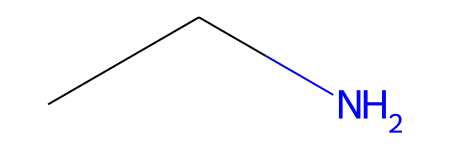

In [87]:
random_mol, random_formula = df[['mol','formula']].sample(n=1).iloc[0]
smiles = Chem.MolToSmiles(random_mol)
print(random_formula)
print(smiles)
Chem.MolFromSmiles(smiles)

In [88]:
error_count = 0
success_count = 0

for index, row in df.iterrows():
    try:
        mol = row['mol']
        smiles = Chem.MolToSmiles(mol)
        new_mol = Chem.MolFromSmiles(smiles)
        if new_mol is not None:
            success_count += 1
        else:
            error_count += 1
    except Exception as e:
        error_count += 1

[03:18:52] SMILES Parse Error: syntax error while parsing: C[SiH3].Cf(i)PS.Cn(O)[siH2].I#I.N#Br.PBr.PClFsi.[SiH2]=[SiH]P.fbr
[03:18:52] SMILES Parse Error: Failed parsing SMILES 'C[SiH3].Cf(i)PS.Cn(O)[siH2].I#I.N#Br.PBr.PClFsi.[SiH2]=[SiH]P.fbr' for input: 'C[SiH3].Cf(i)PS.Cn(O)[siH2].I#I.N#Br.PBr.PClFsi.[SiH2]=[SiH]P.fbr'
[03:18:52] SMILES Parse Error: syntax error while parsing: Br#I.CI.C[SiH3].ClCI(Br)Br.F=P#I.N=P.PCl.ccls-c([siH2])[SiH2][SiH3]
[03:18:52] SMILES Parse Error: Failed parsing SMILES 'Br#I.CI.C[SiH3].ClCI(Br)Br.F=P#I.N=P.PCl.ccls-c([siH2])[SiH2][SiH3]' for input: 'Br#I.CI.C[SiH3].ClCI(Br)Br.F=P#I.N=P.PCl.ccls-c([siH2])[SiH2][SiH3]'
[03:18:52] Explicit valence for atom # 10 F, 2, is greater than permitted
[03:18:52] SMILES Parse Error: syntax error while parsing: C=OO[Si]1(#N)=s(=P)(CCl=fc)clBr1.C=S.CBr.CS[IH]S.N=[SiH2].O#[PH]#O.O#[Si]#ipi(#[SiH])#Cl
[03:18:52] SMILES Parse Error: Failed parsing SMILES 'C=OO[Si]1(#N)=s(=P)(CCl=fc)clBr1.C=S.CBr.CS[IH]S.N=[SiH2].O#[PH]#O.O

In [90]:
print("Percentage of Valid Molecules With Bonds: ", success_count / (error_count + success_count)* 100)

Percentage of Valid Molecules With Bonds:  7.000000000000001
